In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from soda.dataio.conversion.dem import DEM, blendDEMs
from soda.utils.fkriging import kriging

from scipy import spatial
import pdb

import copy

In [2]:
basedir = '/home/suntans/Share/ScottReef/DATA/BATHYMETRY/'

basefile = '%s/dem_GA2009_NWS.nc'%basedir

infile = '%s/GA_WEL_MultiBeam_NWSBrowse_DEM.nc'%basedir #

# Bounds for testing only (Rowley Shoals)
x0 = 118.5
x1 = 120.5
y0 = -18.
y1 = -16.8

# Scott Reef
x0 = 121.5
x1 = 124.5
y0 = -14.5
y1 = -12.0

bufferdist = 6.5/100.
zcutoff = -600.

clip = True

In [3]:
dem1 = DEM(infile, W=10, maxdist=bufferdist)

dem_bg = DEM(basefile, W=1, maxdist=bufferdist)

/home/suntans/code/soda/dataio/conversion/dem.py:147: RuntimeWarning: invalid value encountered in greater
  Z = nc.variables[zvar][:]


In [4]:
if clip:
    dem1.clip(x0,x1,y0,y1)
    dem_bg.clip(x0,x1,y0,y1)

dem1.Z[dem1.Z==0.] = np.nan


<IPython.core.display.Javascript object>


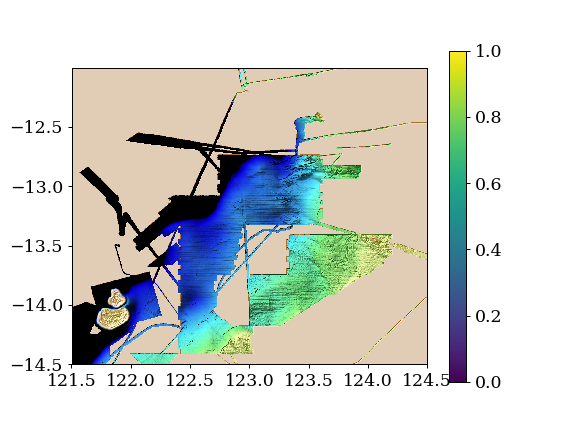

In [5]:
plt.figure()

dem1.plot(vmin=-500, vmax=100)

<IPython.core.display.Javascript object>


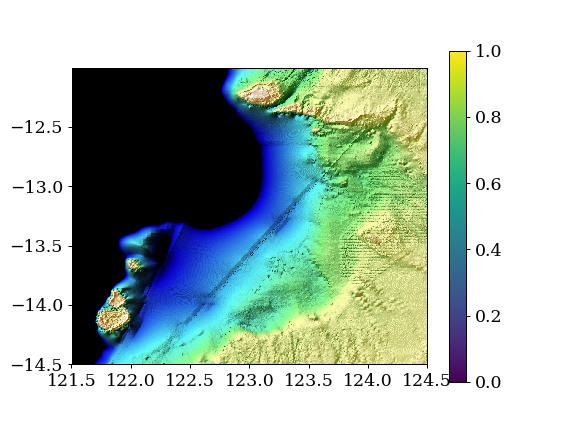

In [6]:
plt.figure()
dem_bg.plot(vmin=-500, vmax=100)

<IPython.core.display.Javascript object>


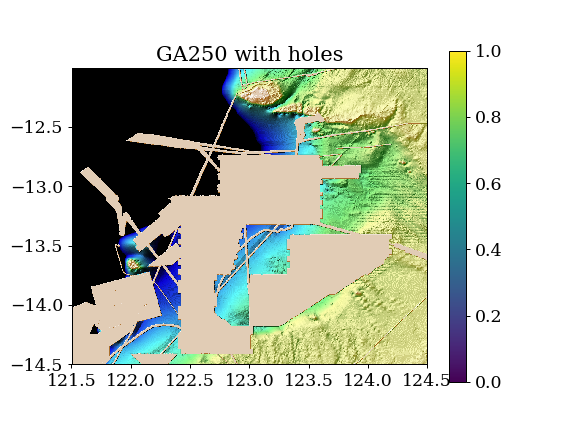

Text(0.5,1,u'GA250 with holes')

In [7]:
# Create a GA-like bathy set with holes where the other data is
#idx = dem1.Z==0.
idx = np.isnan(dem1.Z)

dem_holes = copy.deepcopy(dem_bg)

dem_holes.Z[~idx] = np.nan

plt.figure()
dem_holes.plot(vmin=-500, vmax=100)
plt.title('GA250 with holes')

In [8]:
ff = 4
Xin = dem_holes.X[idx][::ff]
Yin = dem_holes.Y[idx][::ff]
Zin = dem_holes.Z[idx][::ff]

# Now join it with the good data
Xin = np.hstack([Xin, dem1.X[~idx]])
Yin = np.hstack([Yin, dem1.Y[~idx]])
Zin = np.hstack([Zin, dem1.Z[~idx]])

XYout = np.vstack([dem1.X.ravel(), dem1.Y.ravel()]).T
XYin = np.vstack([Xin, Yin]).T


In [9]:
## Method 1: Fill the gaps with Kriging
args = {
    'maxdist':2000,
    'NNear':30,
    'vrange':2500.,
    'nugget':0.1,
    'sill':0.8,
    
}
F = kriging(XYin, XYout, **args)

1197801 interpolation points.


In [10]:
Z = F(Zin)

demout = copy.deepcopy(dem1)
demout.Z = Z.reshape((demout.ny,demout.nx))

<IPython.core.display.Javascript object>


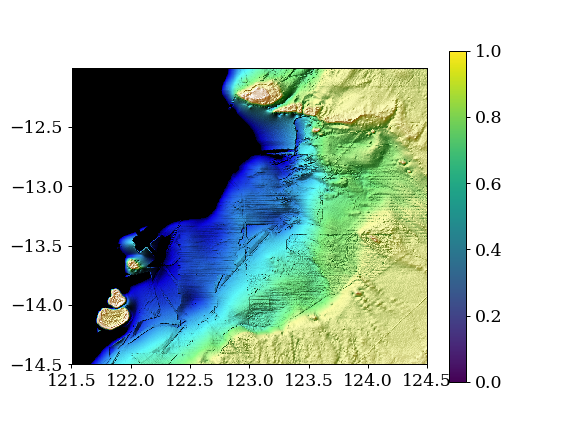

In [11]:

plt.figure()
demout.plot(vmin=-500, vmax=100)

<IPython.core.display.Javascript object>


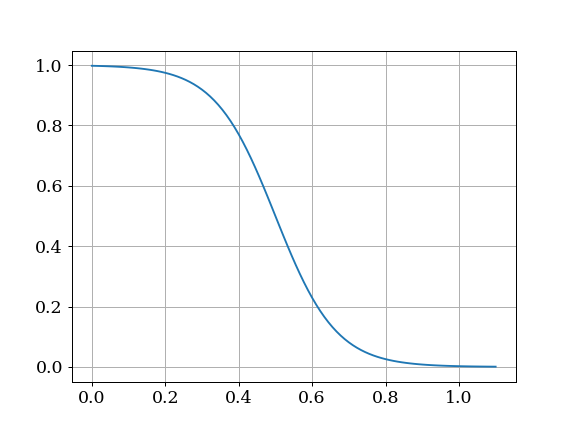

In [20]:
def my_weights(x, maxdist):
    w = (0.5-0.5*np.tanh((2*x-maxdist)/(0.33*maxdist)))
    return w
xtest = np.linspace(0,1.1*bufferdist,100)

plt.figure()
plt.plot(xtest/bufferdist, my_weights(xtest, bufferdist))
plt.grid(b=True)

In [54]:
## Method 2 - Use weigted addition scheme
dem1.maxdist = 6.5/100.
dem_bg.maxdist = 6.5/100.

dem1.W = 1.
dem_bg.W = 1.


#wholes = dem1.calc_weight(weightfunc=my_weights)
wholes = dem1.W*np.ones_like(dem1.Z)
wholes[np.isnan(dem1.Z)]=0.
wbg = dem_bg.calc_weight(weightfunc=my_weights, xynan=dem1.nanxy())


w2 = wbg
w1 = 1-w2


Building KD-tree...


<IPython.core.display.Javascript object>


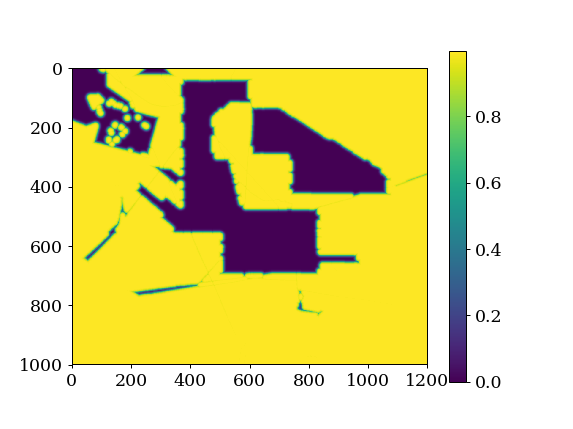

In [56]:
plt.figure()
plt.imshow(w2)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


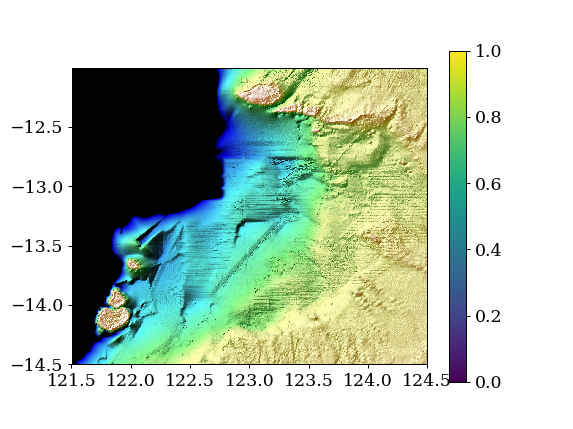

In [57]:
demout3 = copy.deepcopy(dem1)

z1 = w1*dem1.Z
z1[np.isnan(z1)] = 0.
z2 = w2*dem_bg.Z
demout3.Z = z1+z2
plt.figure()
demout3.plot(vmin=-650, vmax=100)


<IPython.core.display.Javascript object>


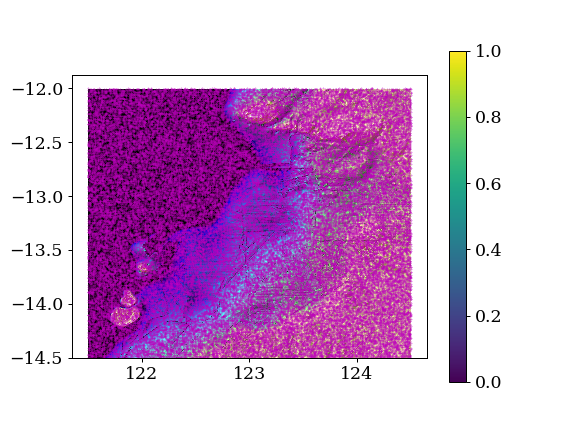

In [15]:
## Method 3 - Try downsampling onto random points instead
sz =dem1.ny*dem1.nx//17
xsample = np.random.uniform(low=x0,high=x1, size=(sz,))
ysample = np.random.uniform(low=y0,high=y1, size=(sz,))

zsample = dem_bg.interp(xsample, ysample)

plt.figure()
demout.plot(vmin=-500, vmax=100)
plt.plot(xsample, ysample,'m.',ms=0.5)

In [16]:
# Create a buffer zone
print 'Finding the buffer zone...'
#idx = ~np.isnan(dem1.Z)
XY_wel = np.column_stack([dem1.X[~idx], dem1.Y[~idx]])

# compute the spatial tree
kd = spatial.cKDTree(XY_wel)  

# Distance of the GA data to WEL points
print 'spatial querying...'
XY_ga = np.column_stack([xsample, ysample])

dist, ind = kd.query(XY_ga)

# These are the points to blank out
#idx_ga = operator.or_(dist < bufferdist, dem_bg.Z.ravel() > zcutoff )
idx_buffer = dist > bufferdist # Distance only cutoff

#idx_buffer = ((dist > bufferdist) & (zsample>zcutoff))  | ((dist > 3*bufferdist) & (zsample < zcutoff))

#idx_buffer = np.reshape(idx_buffer,(demout.ny,demout.nx))
idx2 = idx_buffer

# These are the good points
idx_buffer3 = dist < 0.0
#idx_buffer = np.reshape(idx_buffer,(demout.ny,demout.nx))
idx3 = ~idx_buffer3

Finding the buffer zone...
spatial querying...


<IPython.core.display.Javascript object>


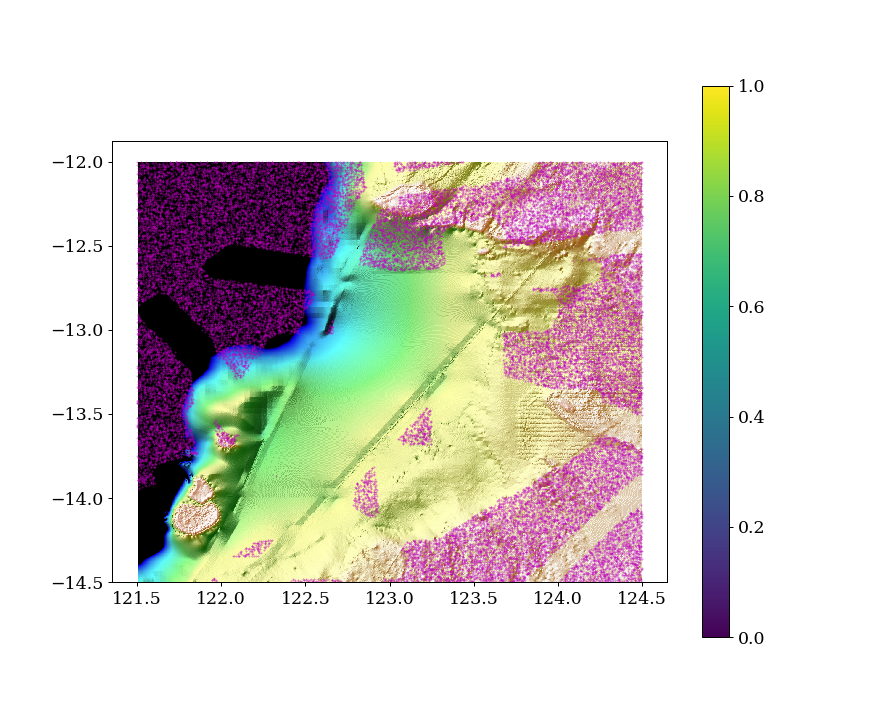

In [17]:
plt.figure(figsize=(10,8))
dem_bg.plot(vmin=-1000, vmax=100)
plt.plot(xsample[idx2], ysample[idx2],'m.',ms=0.5)

In [18]:

# Now join it with the good data
#Xin2 = np.hstack([xsample[idx2], dem1.X[~idx]])
#Yin2 = np.hstack([ysample[idx2], dem1.Y[~idx]])
#Zin2 = np.hstack([zsample[idx2], dem1.Z[~idx]])

# ...or Randomly sample the good data

# Good data at the sample sites
zsample2 = dem1.interp(xsample[idx3], ysample[idx3])
Xin2 = np.hstack([xsample[idx2], xsample[idx3]])
Yin2 = np.hstack([ysample[idx2], ysample[idx3]])
Zin2 = np.hstack([zsample[idx2], zsample2])

XYin2 = np.vstack([Xin2, Yin2]).T

In [19]:
# Fill the gaps with Kriging
args = {
    'maxdist':2000,
    'NNear':37,
    'vrange':3*bufferdist,
    'nugget':0.3,
    'sill':0.7,
    
}
F2 = kriging(XYin2, XYout, **args)

1197801 interpolation points.


In [20]:
Z = F2(Zin2)

demout2 = copy.deepcopy(dem1)
demout2.Z = Z.reshape((demout2.ny,demout2.nx))

# Find the indices that were previously good
#jj,ii = dem1.returnij(xsample, ysample)
#idx3 = idx[jj,ii]

#demout2.Z[~idx] = dem1.Z[~idx]

<IPython.core.display.Javascript object>


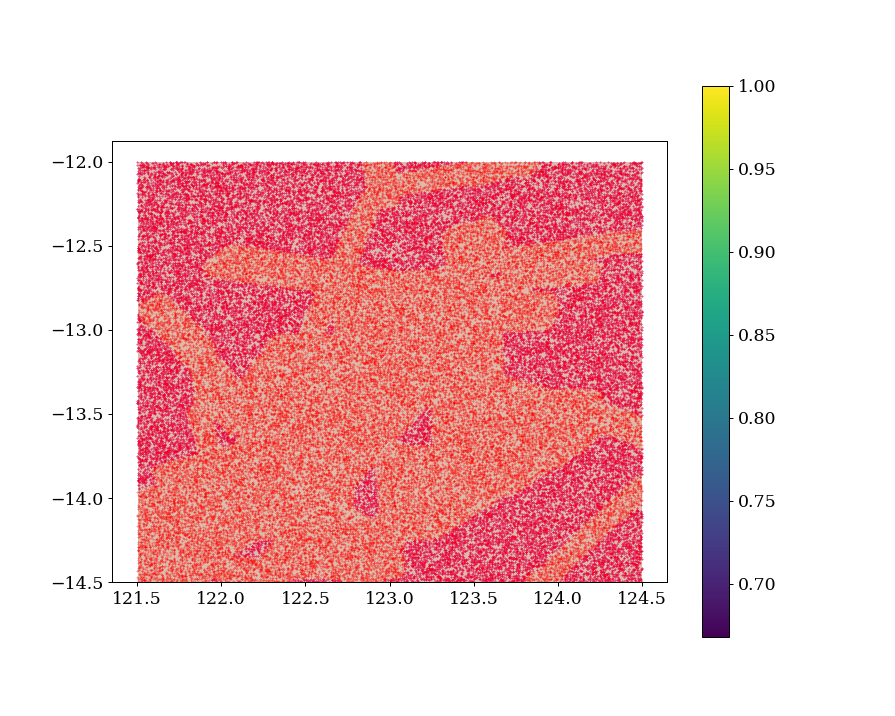

In [21]:
plt.figure(figsize=(10,8))
demout2.plot(vmin=-1000, vmax=100)
plt.plot(xsample[idx2], ysample[idx2],'m.',ms=0.5)
plt.plot(xsample[idx3], ysample[idx3],'r.',ms=0.5)

<IPython.core.display.Javascript object>


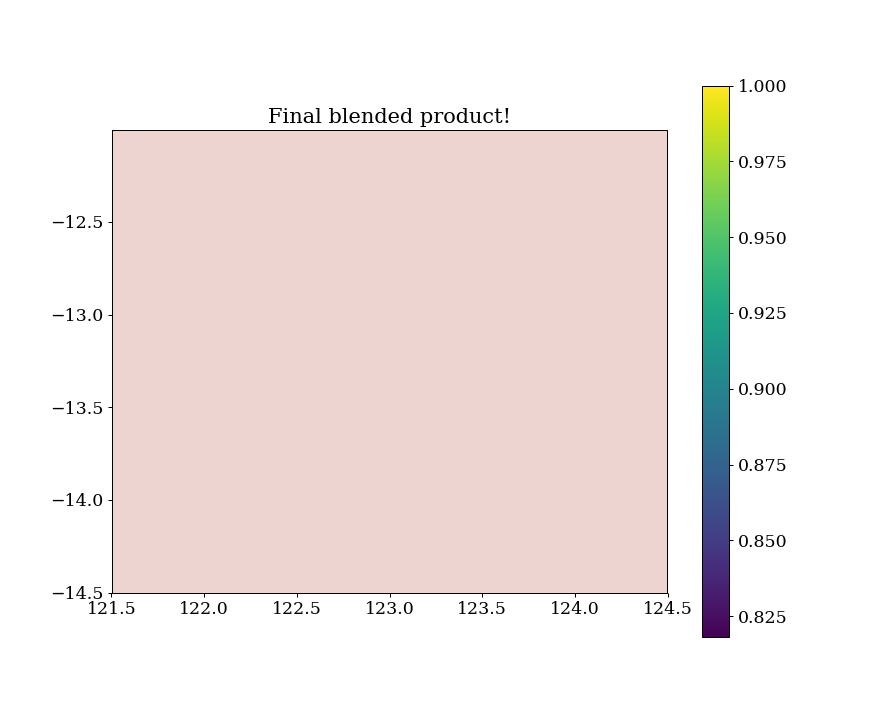

Text(0.5,1,u'Final blended product!')

In [22]:
plt.figure(figsize=(10,8))
demout2.plot(vmin=-2000, vmax=100)
plt.title('Final blended product!')